## Assignment for Week 7 - Performance Evaluations

### Project:
#### Performance Evaluations: ROC and PR Curves

Bank Marketing data:  https://archive.ics.uci.edu/ml/datasets/bank+marketing

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. 

From the given data set, complete the following:
  * Try 3 different types of models to make classification predictions on the bank marketing dataset 
  * Calculate the AUC score as a comparison, and at least 2 other metrics (ie: accuracy, F1 score, precision, recall, etc) 
      - Compare the models’ performance on the same train/test splits 
  * Plot the ROC curve from the best model, choose what you think the best threshold value is for making predictions

### Deliverables:

Upload your notebook's .ipynb file.
   
**Important:** Make sure your provide complete and thorough explanations for all of your analysis. You need to defend your thought processes and reasoning.

In [1]:
import pandas as pd 
import numpy as np 

# PLOTTING 
import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.express as px

# MACHINE LEARNING MODELS

## Data prep
from sklearn.model_selection import train_test_split

# Logistic Regression
from sklearn.linear_model import LogisticRegression

# Linear Support Vector Machine 
from sklearn.svm import SVC

# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# EVALUATION
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import learning_curve

### EDA

In [2]:
df = pd.read_csv('data_wk7/bank-additional-full.csv', index_col=0, encoding='utf-8', sep=';')
df.head()

,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
age,,,,,,,,,,,,,,,,,,,,
56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
# Checking for null values
df.isna().sum()

job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41188 entries, 56 to 74
Data columns (total 20 columns):
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y                 41188 non-null object
dtypes: float64(5), int64(4), object(11)
memory usage: 6.6+ MB


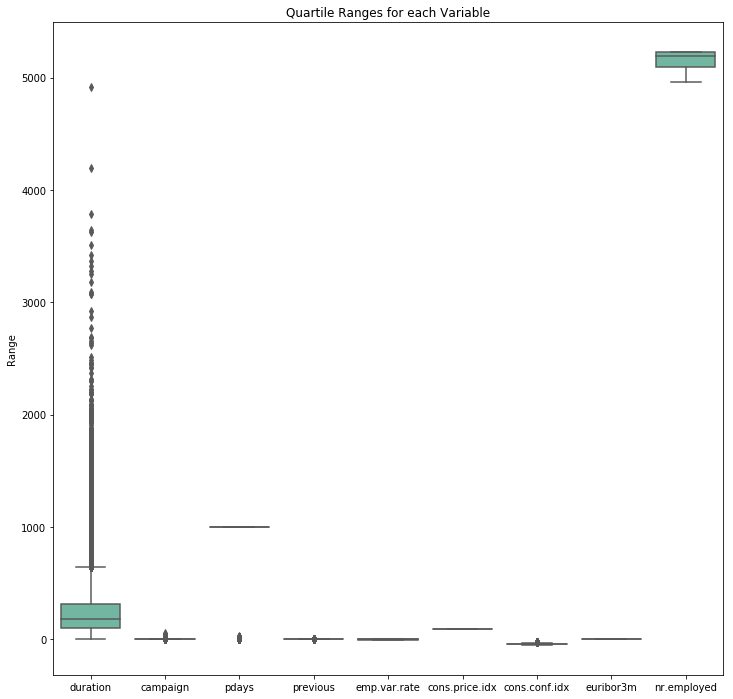

In [5]:
fig = plt.figure(figsize=(12,12))
x_range = pd.cut(range(len(df)), 5)
plt.title('Quartile Ranges for each Variable')
ax = sns.boxplot(data=df, palette="Set2").set(
    ylabel="Range"
)

The distributions are very wide for duration, however there are tight ranges of data for most variables and low variance. The `nr.employed` variable has a higher value but lower variance, as it represents the number of employees. 

In [6]:
# Data preprocessing
from sklearn.preprocessing import LabelEncoder

labels = LabelEncoder()

# encode all variables 
model_data = pd.DataFrame({k: labels.fit_transform(x) for (k, x) in df.items()})


In [7]:
model_data.head()

,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,3,1,0,0,0,0,1,6,1,261,0,26,0,1,8,18,16,287,8,0
1,7,1,3,1,0,0,1,6,1,149,0,26,0,1,8,18,16,287,8,0
2,7,1,3,0,2,0,1,6,1,226,0,26,0,1,8,18,16,287,8,0
3,0,1,1,0,0,0,1,6,1,151,0,26,0,1,8,18,16,287,8,0
4,7,1,3,0,0,2,1,6,1,307,0,26,0,1,8,18,16,287,8,0


The data is now numerically transformed for ordinal data and continuous data, so the models will be able to work with it much more efficiently. 

In [8]:
x = model_data[[column for column in model_data.columns if column != 'y']].reset_index()
y = model_data['y']

# Creating training and testing data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, shuffle=True, random_state=42)

### Machine Learning Models

#### Logistic Regression

In [9]:
model = LogisticRegression()
model.fit(x_train, y_train)

#gathering the predictions
preds = model.predict(x_test)

C:\Users\rschr\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


#### Evaluation

_Accuracy Score_

In [10]:
print(f"\t\t\tACCURACY SCORE\n", "    \n\t\t\t\t", "{:.0%}".format((accuracy_score(y_test,preds))))

			ACCURACY SCORE
     
				 91%


Logistic Regression has a high accuracy, as typical for this model! However, this is just the surface of how we can assess the model's performance.

_Classification Report_

A classification report will detail more important details including: 
- Precision: The rate at which the model predicts true positive values. True Positives / True Positives + False Positives
- Recall: The recollection of predictions as they are truly positive while not falsely negative. True Positives /  True Positives + False Negatives
- F1 Score: The F-Statistic, or overall significance of the model as a probability based upon its precision and recall mean

In [11]:
print(f"\t\t\tCLASSIFICATION REPORT\n", "    \n",(classification_report(y_test,preds)))

			CLASSIFICATION REPORT
     
               precision    recall  f1-score   support

           0       0.93      0.97      0.95      7303
           1       0.67      0.44      0.53       935

   micro avg       0.91      0.91      0.91      8238
   macro avg       0.80      0.70      0.74      8238
weighted avg       0.90      0.91      0.90      8238



_Confusion Matrix_

The confusion matrix shows us the actual spread of predictions for true positives, false positives, true negatives, and false negatives. This supports the classification report to show further how the model actually performed.

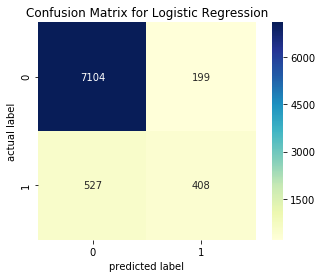

In [12]:
cm = confusion_matrix(y_test, preds)
target_labels = np.unique(y_test)

sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True, cmap="YlGnBu",
            xticklabels=target_labels, yticklabels=target_labels)
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('predicted label')
plt.ylabel('actual label');

_ROC Curve_

Probability predictions are assessed with Cross-Validation, and using such methods will determine the percentage of the time the predictions have the highest probability of correctness, more in depth than the confusion matrix. 

In [13]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import roc_curve

def ROC_Curve(title, model, x_train, y_train, label=None):
    
    predict_proba = cross_val_predict(model, x_train, y_train, cv=3, method='predict_proba')
    proba_scores = predict_proba[:, 1]

    # calculate the ROC score
    fpr, tpr, thresholds = roc_curve(y_train, proba_scores)
    print('AUC Score ({}): {:.2f} '.format(title, roc_auc_score(y_train, proba_scores)))
    
    # plot the ROC curve
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, linewidth=2, label=label, color='b')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC Curve: {}'.format(title), fontsize=16)
    plt.show()

C:\Users\rschr\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\rschr\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\rschr\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC Score (Subscription to Term Deposit for Logistic Regression): 0.92 


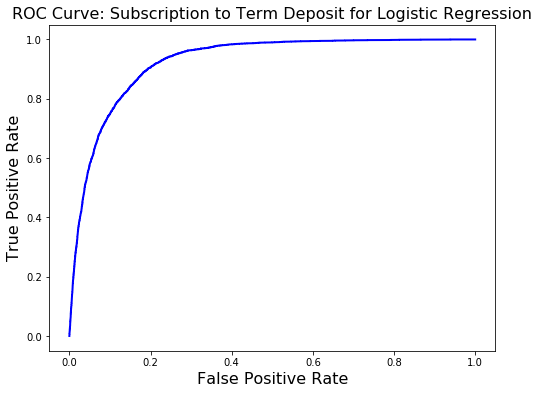

In [14]:
ROC_Curve('Subscription to Term Deposit for Logistic Regression', model, x_train, y_train)

The ROC curve shows a low false-positive rate only when the model starts leraning, but approaches a very good true positive rate early on, which is good. The best assessment point for a model with this graph is the nearest the top left portion of the trend curve. The closer to a 90-degree angle, the better the model. 

#### Support Vector Machine

In [15]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

svc = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True))
svc.fit(x_train, y_train)

svc_preds = svc.predict(x_test)

C:\Users\rschr\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\rschr\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\rschr\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


#### Evaluation

_Accuracy Score_

In [16]:
print(f"\t\t\tACCURACY SCORE\n", "    \n\t\t\t\t", "{:.0%}".format((accuracy_score(y_test, svc_preds))))

			ACCURACY SCORE
     
				 91%


_Classification Report_

In [17]:
print(f"\t\t\tCLASSIFICATION REPORT\n", "    \n",(classification_report(y_test, svc_preds)))

			CLASSIFICATION REPORT
     
               precision    recall  f1-score   support

           0       0.93      0.98      0.95      7303
           1       0.68      0.41      0.51       935

   micro avg       0.91      0.91      0.91      8238
   macro avg       0.80      0.69      0.73      8238
weighted avg       0.90      0.91      0.90      8238



_Confusion Matrix_

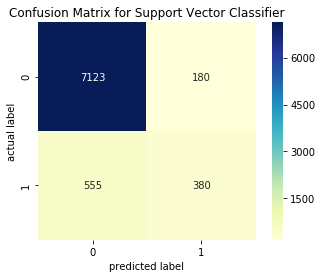

In [18]:
cm = confusion_matrix(y_test, svc_preds)
target_labels = np.unique(y_test)

sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True, cmap="YlGnBu",
            xticklabels=target_labels, yticklabels=target_labels)
plt.title('Confusion Matrix for Support Vector Classifier')
plt.xlabel('predicted label')
plt.ylabel('actual label');

_ROC Curve_

C:\Users\rschr\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\rschr\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\rschr\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\rschr\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\rschr\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int32, int64 were all convert

AUC Score (Subscription to Term Deposit for Support Vector Machine): 0.90 


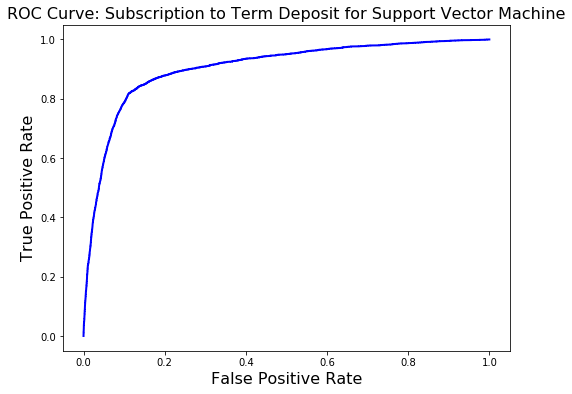

In [19]:
ROC_Curve('Subscription to Term Deposit for Support Vector Machine', svc, x_train, y_train)

#### Random Forest 

In [20]:
rf = RandomForestClassifier(n_estimators=10)
rf = rf.fit(x_train, y_train)

rf_preds = rf.predict(x_test)

#### Evaluation

_Accuracy Score_

In [21]:
print(f"\t\t\tACCURACY SCORE\n", "    \n\t\t\t\t", "{:.0%}".format((accuracy_score(y_test, rf_preds))))

			ACCURACY SCORE
     
				 91%


_Classification Report_

In [22]:
print(f"\t\t\tCLASSIFICATION REPORT\n", "    \n",(classification_report(y_test, rf_preds)))

			CLASSIFICATION REPORT
     
               precision    recall  f1-score   support

           0       0.93      0.96      0.95      7303
           1       0.62      0.47      0.53       935

   micro avg       0.91      0.91      0.91      8238
   macro avg       0.78      0.72      0.74      8238
weighted avg       0.90      0.91      0.90      8238



_Confusion Matrix_

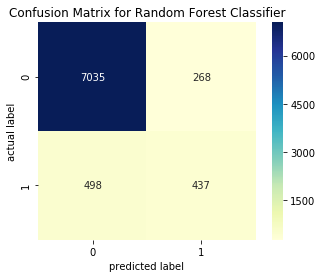

In [23]:
cm = confusion_matrix(y_test, rf_preds)
target_labels = np.unique(y_test)

sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True, cmap="YlGnBu",
            xticklabels=target_labels, yticklabels=target_labels)
plt.title('Confusion Matrix for Random Forest Classifier')
plt.xlabel('predicted label')
plt.ylabel('actual label');

_ROC Curve_

AUC Score (Subscription to Term Deposit for Random Forest): 0.92 


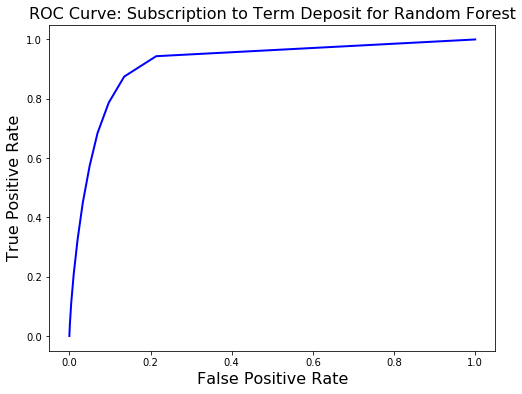

In [24]:
ROC_Curve('Subscription to Term Deposit for Random Forest', rf, x_train, y_train)

# Conclusion

The comparisons show a very similar accuracy for each model, however when looking at the true positive rate as well as the true positive predictions, the Support Vector Machine appears to be most efficient in this case. The sharp cut at 80% accuracy in the top-left portion of its ROC curve shows a less favorable truth to the model that it takes longer to improve, but the number of true predictions shows the SVC is not overfit, well assumed for probability estimation, and minimal of error. When assessing performance, the ROC curve appears most effective to show a trend during validation which helps to finely understand how the model performs as it learns.